### **Tess Vu**
### **MUSA 6950**
### **Dr. Xiaojiang Li**

# **Assignment 4: Urban Shadow Analysis Using GPU Programming**

Follow the tutorial and conduct the shadow analysis on the digital surface model using GPU CUDA programming. Please calculate the shadow map from 8 am to 5 pm for any specified day. You can use the [NOAA Solar Calculator](https://gml.noaa.gov/grad/solcalc/azel.html) to help you determine the solar positions. Please export your shadow maps and generate a gif to show the spatio-temporal pattern of the shadow in one day.

*Hint: You can create a loop of the solar positions and then export the shadow maps of different hours.*
```
solarpos = [(8, azimuth1, ele1), (9, azimuth2, ele2), ..., (17, azimuth17, ele17)]

for hour, azimuth, ele in solarpos:

      calculate the shadow

      export the shadow map as hour.png
```

Merge your shadow maps into a gif file.

### **GPU Programming for Urban Analysis**
1. Configure the computing enviornment.
2. Import PyCUDA module.
3. "Hello World!" version of PyCUDA for slope estimation.
4. Calculate the shadow distribution.

#### **1. Prepare Modules**

In [2]:
from pycuda.compiler import SourceModule
import pycuda
from pycuda import gpuarray
from pycuda import compiler
import pycuda.autoinit # PyCuda autoinit.
import pycuda.driver as cuda # PyCuda In, Out helpers.
from IPython.display import Image
import os, os.path
import rasterio as rio
from osgeo import gdal
from osgeo.gdalconst import *
import numpy as np
import rasterio
import time
import math
import imageio.v3 as iio
# Load the Drive helper and mount.
import matplotlib.cm as colormap # Library to plot.
import numpy # Fast math library.
import matplotlib.image as mpimg # Reading images to numpy arrays.
import matplotlib.pyplot as plt # Plot any graph.
import scipy.ndimage as ndi # tDetermine shape centrality.
# PyCuda setup.
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
# matplotlib setup.
%matplotlib inline
from pylab import rcParams

rcParams["figure.figsize"] = (8, 8) # Setting default size of plots.

print("pycuda installed and ready to use.")

print("%d device(s) found." % cuda.Device.count())
for ordinal in range(cuda.Device.count()):
    dev = cuda.Device(ordinal)
    print ("Device #%d: %s" % (ordinal, dev.name()))
print (cuda)

pycuda installed and ready to use.
1 device(s) found.
Device #0: NVIDIA GeForce RTX 4070 Laptop GPU
<module 'pycuda.driver' from 'c:\\Users\\Tess\\.conda\\envs\\geoai\\Lib\\site-packages\\pycuda\\driver.py'>


In [4]:
# Load Philadelphia, PA's DSM data.
dsm_file = "row11-col17.tif"
os.path.exists(dsm_file) # Check if the file exists.

dsm_dataset = rio.open(dsm_file) # Open the DSM file.

dsm_bounds = dsm_dataset.bounds # Get the bounds of the DSM.
dsm_img = dsm_dataset.read(1) # Read the first band of the DSM.
print("DSM Bounds:", dsm_bounds)

transform = dsm_dataset.transform # Affine transformation matrix.

# The pixel width and height (scale) can be found as follows:
pixel_width = transform[0]  # Scale in the x-direction.
pixel_height = -transform[4]  # Scale in the y-direction (usually negative).

# Calculate a unified scale if needed (average or reciprocal).
scale = 1 / pixel_width  # This will give a scale factor.

# Print affine transformation matrix.
transform

DSM Bounds: BoundingBox(left=2712748.0, bottom=259294.0, right=2717948.0, top=264494.0)


Affine(2.0, 0.0, 2712748.0,
       0.0, -2.0, 264494.0)

##### Affine transformation notes:
| a, b, c |

| d, e, f |

a = 2.0: Pixel width. Each pixel represents 2 units in the x-direction. Going right.

b = 0.0: x-rotation row skew. No rotation nor shear.

c = 2,712,748.0: Upper left corner's x-coordinate.

d = 0.0: y-rotation column skew. No rotation nor shear.

e = -2.0: Pixel height. Each pixel represents 2 units in the y-direction. Going down.

f = 4,173,254.0: Upper left corner's y-coordinate.

#### **2. PyCUDA Kernel for Slope Calculation**


In [5]:
# Define the CUDA kernel for slope calculation for execution in the GPU, but called from CPU.
    # Each GPU thread is responsible for a single pixel in the DSM image.
    # Skips edges to avoid out-of-bounds errors and makes sure all pixels have 4 direct neighbors.
    # Computes elevation changes in x and y and calculates slope angle in degrees.
kernel_code = """

/* Calculate_slope function in C++ with parameters:

*dsm: Pointer to memory location of DSM data.
*slope: Pointer to memory location of slope data.
width: Width of the DSM image.
height: Height of the DSM image.
cell_size: Size of each cell in the DSM (resolution). */

__global__ void calculate_slope(float *dsm, float *slope, int width, int height, float cell_size) {
    
    // Calculates and converts 2D block/thread structure into pixel coordinates (x, y).
    int x = blockDim.x * blockIdx.x + threadIdx.x;
    int y = blockDim.y * blockIdx.y + threadIdx.y;

    /* Subtract the width and height by 1 to avoid edges.
    When calculating slope, pixels need to be surrounded on all sides,
    so we need to make sure all pixels have encompassing neighbors. */

    if (x > 0 && x < width - 1 && y > 0 && y < height - 1) {
        
        // Calculate gradient in x and y directions.
        // Rate of change in elevation along x (east to west) directions.
        float dzdx = (dsm[y * width + (x + 1)] - dsm[y * width + (x - 1)]) / (2 * cell_size);
        
        // Rate of change in elevation along y (north to south) directions.
        float dzdy = (dsm[(y + 1) * width + x] - dsm[(y - 1) * width + x]) / (2 * cell_size);

        // Calculate slope.
        // Convert gradient magnitude to slope angle in radians, then to degrees.
        slope[y * width + x] = atan(sqrt(dzdx * dzdx + dzdy * dzdy)) * 180 / 3.14159;
    }
}
"""

# Compile the kernel (translate CUDA kernel source code into executable machine code).
mod = SourceModule(kernel_code)
calculate_slope = mod.get_function("calculate_slope")

In [6]:
# Load Philadelphia, PA's DSM data.
dsm_dataset = rio.open(dsm_file)

# Get DSM bounds and image data from band 1.
dsm_bounds = dsm_dataset.bounds
dsm_img = dsm_dataset.read(1)
print("DSM Bounds:", dsm_bounds)

# Prepare data.
dsm = dsm_img.astype(np.float32)
height, width = dsm.shape
cell_size = 1.0  # Assuming cell size is 1 meter; adjust according to DSM metadata.

# Allocate memory on the GPU. This is where the *dsm and *slope pointers in the kernel code "point" to.
# d_ notation to differentiate device (GPU) from host (CPU).
d_dsm = cuda.mem_alloc(dsm.nbytes)
d_slope = cuda.mem_alloc(dsm.nbytes)

# Copy DSM data from host to device.
cuda.memcpy_htod(d_dsm, dsm)

DSM Bounds: BoundingBox(left=2712748.0, bottom=259294.0, right=2717948.0, top=264494.0)


*Choosing the block size dimensions in CUDA depends on several factors, including the structure of your data, the size of your computation, and the hardware limitations of your GPU.*

*CUDA’s warps (groups of 32 threads) run efficiently with blocks sized as multiples of 32.*

- *A common choice is (16, 16) or (32, 32), balancing parallelism and shared memory usage.*

- *A larger block size (e.g. (32, 32)) reduces scheduling overhead but increases shared memory use.*

In [7]:
# Define block and grid size.
# 1 → Number of threads in the z-direction (which is not used in 2D computations).
block_size = (16, 16, 1)

# Number of blocks in the x and y directions.
grid_size = (int(np.ceil(width / block_size[0])), int(np.ceil(height / block_size[1])))

# Run the kernel.
calculate_slope(d_dsm, d_slope,
                # Cast to appropriate types for the kernel. Python int has arbitrary size. CUDA's C++ needs 32-bits.
                np.int32(width), np.int32(height), np.float32(cell_size),
                block = block_size, grid = grid_size)

In [8]:
# Create an empty array for the result on the host.
# empty_like creates an array with the same shape and data type as the input.
slope = np.empty_like(dsm)

# Copy result from device back to host.
cuda.memcpy_dtoh(slope, d_slope)

# Free GPU memory to signal to GPU that runtime is done.
d_dsm.free()
d_slope.free()

#### **3. Compute Shadow Distribution**

In [9]:
# Define the CUDA kernel for the shadow calculation.

kernel_shadow = """

// Define PI as 3.1415926.

__global__ void calculate_shadow(float *dsm, bool *shadow, int width, int height, float cell_size, float sun_azimuth, float sun_elevation) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    
    // Check if the thread is within the bounds of the image.
    if (x >= width || y >= height)
        return;

    int idx = y * width + x;

    // Convert sun azimuth and elevation to radians.
    float azimuth_rad = sun_azimuth * 3.14159 / 180.0;
    float elevation_rad = sun_elevation * 3.14159 / 180.0;

    // Direction of the shadow ray based on sun azimuth.
    float dx = sin(azimuth_rad);
    float dy = -cos(azimuth_rad);
    float dz = tan(elevation_rad);

    // Initial height at the current pixel.
    float initial_height = dsm[idx];
    bool in_shadow = false;

    // Trace the shadow ray.
    for (float t = cell_size; t < 2000.0f; t += cell_size) { // Limit tracing distance.
        int x_offset = x + int(dx * t / cell_size);
        int y_offset = y + int(dy * t / cell_size);

        if (x_offset < 0 || x_offset >= width || y_offset < 0 || y_offset >= height)
            break; // Out of bounds.

        int offset_idx = y_offset * width + x_offset;

        // Calculate height along the ray.
        float height_along_ray = initial_height + dz * t;

        // Check if there's a higher point along the path.
        if (dsm[offset_idx] > height_along_ray) {
            in_shadow = true;
            break;
        }
    }

    // Store shadow result: 1 for shadow, 0 for no shadow.
    shadow[idx] = in_shadow;
}
"""

# Compile the kernel (translate CUDA kernel source code into executable machine code).
mod = SourceModule(kernel_shadow)
calculate_shadows = mod.get_function("calculate_shadow")

C:\Users\Tess\AppData\Local\Temp\ipykernel_49548\1738734304.py:56: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  mod = SourceModule(kernel_shadow)


In [10]:
# Prepare parameters and allocate memory.
height, width = dsm_img.shape

# Initialize shadow output array on CPU.
shadow_result = np.zeros_like(dsm_img, dtype = bool)

# Define cell size.
cell_size = 1.0 # Adjust based on DSM resolution, e.g. 1 meter per pixel.

# Define block and grid size.
block_size = (16, 16, 1)
grid_size = (int(np.ceil(width / block_size[0])), int(np.ceil(height / block_size[1])))

# For July 14, 1998.
solar_position = [(8, 90.06, 35.17), (9, 100.66, 46.6), (10, 114.84, 57.54), (11, 137.43, 66.87), (12, 175.24, 71.63),
            (13, 215.82, 68.43), (14, 241.22, 59.72), (15, 256.65, 48.99), (16, 267.78, 37.61), (17, 277.13, 26.15)]

# Allocate memory for input DSM and output shadow map.
d_dsm = cuda.mem_alloc(dsm_img.nbytes)
d_shadow = cuda.mem_alloc(shadow_result.nbytes) # Shadow result (boolean).

# Copy the shadow results from device back to the host.
cuda.memcpy_htod(d_dsm, dsm_img)

# Create a loop of the solar positions and then export the shadow maps of different hours.
for hour, azimuth, elevation in solar_position:
    # Convert sun angles to float32 and launch the kernel to calculate shadows.
    calculate_shadows(
        d_dsm, d_shadow, np.int32(width), np.int32(height),
        np.float32(cell_size), np.float32(azimuth), np.float32(elevation),
        block = block_size, grid = grid_size
    )
    
    # Wait for synchronization, some threads may finish faster than others.
    cuda.Context.synchronize()

    # Copy shadow results from device back to host.
    cuda.memcpy_dtoh(shadow_result, d_shadow)

    # Convert from boolean array to binary array for image processing.
    binary_shadow = np.logical_not(shadow_result).astype(np.uint8) # 1 for True (non-shadow), 0 for False (shadow) for more natural aesthetic.

    # Create output folder and define path for folder.
    output_folder = "shadows"

    # Create the new folder if it doesn't exist.
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # File name.
    file_name = f"hour_{hour}.png"

    # File path.
    file_path = os.path.join(output_folder, file_name)

    # Export the shadow map as hour.png in folder.
    plt.imsave(file_path, binary_shadow, cmap = "gray")

    # Print check.
    print(f"Shadow hour {hour}.")

# Free GPU memory to signal to GPU that runtime is done.
d_dsm.free()
d_shadow.free()

Shadow hour 8.
Shadow hour 9.
Shadow hour 10.
Shadow hour 11.
Shadow hour 12.
Shadow hour 13.
Shadow hour 14.
Shadow hour 15.
Shadow hour 16.
Shadow hour 17.


#### **5. Make GIF**

In [11]:
# Define the shadows folder.
shadows_folder = "shadows"

# Create empty list for png images to make gif.
gif_images = []

# Loop through folder pngs and read the files into gif_images empty list.
for file_name in sorted(os.listdir(shadows_folder)):
    if file_name.endswith(".png"):
        file_path = os.path.join(shadows_folder, file_name)
        image = iio.imread(file_path)
        gif_images.append(image)

# Save as an animated GIF.
# Declare gif path.
gif_path = "shadows.gif"

# Write gif, specify 500 ms duration with looping.
iio.imwrite(gif_path, gif_images, duration = 500, loop = 0)

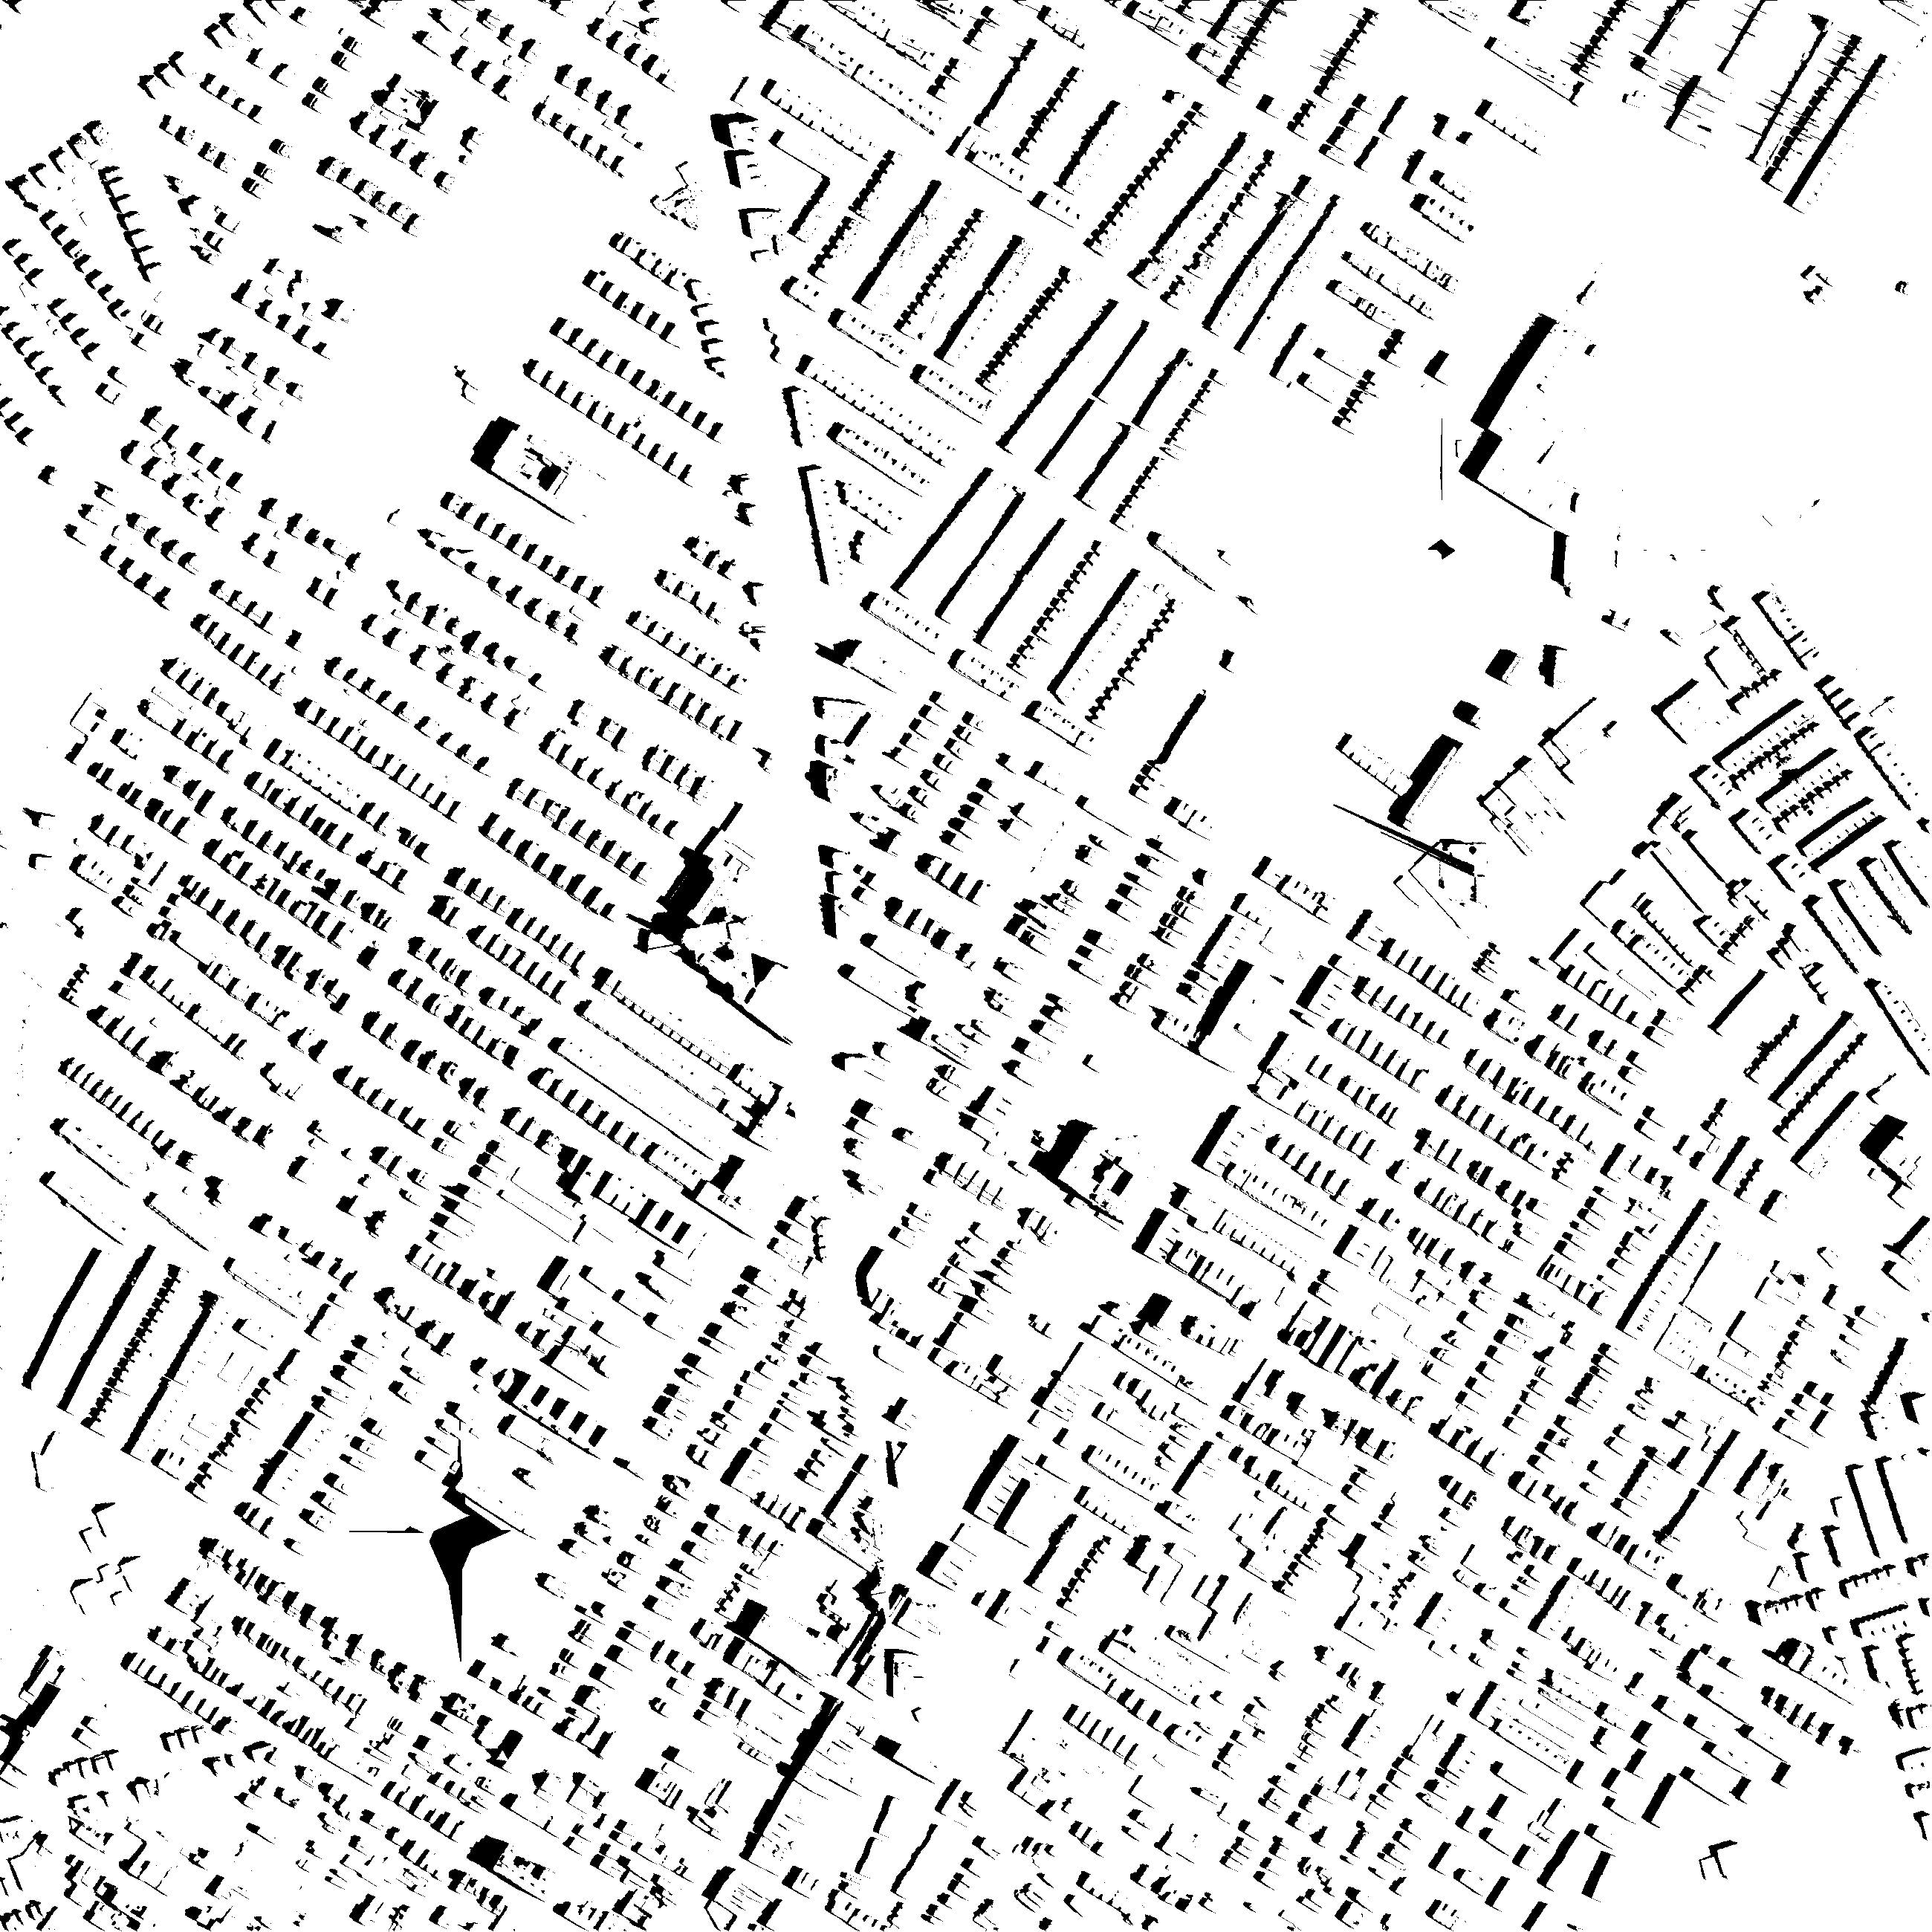

In [12]:
Image(filename = "shadows.gif", width = 500, height = 500)